In [17]:
import torch
import numpy as np
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from dataset import ViTacDataset
from torch.utils.tensorboard import SummaryWriter
import argparse
from torch import nn
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(message)s")

log = logging.getLogger()

In [3]:
# parser = argparse.ArgumentParser("Train model.")
# parser.add_argument("--epochs", type=int, help="Number of epochs.", required=True)
# parser.add_argument("--data_dir", type=str, help="Path to data.", required=True)
# parser.add_argument(
#     "--checkpoint_dir", type=str, help="Path for saving checkpoints.", required=True
# )

# parser.add_argument("--lr", type=float, help="Learning rate.", required=True)
# parser.add_argument(
#     "--sample_file", type=int, help="Sample number to train from.", required=True
# )
# parser.add_argument(
#     "--batch_size", type=int, help="Batch Size.", required=True
# )

In [4]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'
        self.batch_size = 8
        self.sample_file = 1
        self.lr = 0.01
        self.epochs = 100
args = FLAGS()

In [5]:
device = torch.device("cuda:1")
writer = SummaryWriter(".")

In [6]:
train_dataset = ViTacDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt"
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4
)
test_dataset = ViTacDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt"
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4
)

In [336]:
class MLP_LSTM(nn.Module):

    def __init__(self):
        super(MLP_LSTM, self).__init__()
        self.input_size = 156
        self.hidden_dim = 32
        self.num_layers = 1

        # Define the LSTM layer
        self.gru = nn.GRU(self.input_size, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.fc = nn.Linear(self.hidden_dim, 20)
        
        #self.fc_mlp = nn.Linear(156, self.input_size)

    def forward(self, input_data):
#         print('In data:', input_data.shape)

        #gru_in = self.fc_mlp(input_data)#.permute(0,2,1)
        gru_in = input_data
#         print('mlp out:', gru_in.shape, len(gru_in))
        
        gru_in = gru_in.permute(1,0,2)
        print('gru in:', gru_in.shape, len(gru_in))
        gru_out, self.hidden = self.gru(gru_in)
#         print('gru out:', gru_out.shape)
        
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(gru_out[-1, :, :])
        
        #print(y_pred.shape)
        return y_pred

In [337]:
net = MLP_LSTM().to(device)
# Create snn loss instance.
criterion = nn.CrossEntropyLoss()
# Define optimizer module.
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=0.0001)

In [338]:
train_accs = []
test_accs = []
train_loss = []
test_loss = []
for epoch in range(1, args.epochs+1):
    # Training loop.
    net.train()
    correct = 0
    batch_loss = 0
    train_acc = 0
    for i, (in_tact, _, _, label) in enumerate(train_loader, 0):

        in_tact = in_tact.to(device)
        in_tact = in_tact.squeeze()
        in_tact = in_tact.permute(0,2,1)
        label = label.to(device)
        # Forward pass of the network.
        out_tact = net.forward(in_tact)
        #print(out_tact.shape)
        # Calculate loss.
        #print(label.shape)
        loss = criterion(out_tact, label)
        #print(loss)

        batch_loss += loss.cpu().data.item()
        # Reset gradients to zero.
        optimizer.zero_grad()
        # Backward pass of the network.
        loss.backward()
        # Update weights.
        optimizer.step()

        _, predicted = torch.max(out_tact.data, 1)
        correct += (predicted == label).sum().item()

    # Reset training stats.
    train_acc = correct/len(train_loader.dataset)
    train_loss.append(batch_loss/len(train_loader.dataset))
    train_accs.append(train_acc)
    #print(train_acc, batch_loss)

    # testing
    net.eval()
    correct = 0
    batch_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, (in_tact, _, _, label) in enumerate(test_loader, 0):
            in_tact = in_tact.to(device)
            in_tact = in_tact.squeeze()
            in_tact = in_tact.permute(0,2,1)

            # Forward pass of the network.
            out_tact = net.forward(in_tact)
            label = label.to(device)
            _, predicted = torch.max(out_tact.data, 1)
            correct += (predicted == label).sum().item()
            # Calculate loss.
            loss = criterion(out_tact, label)
            batch_loss += loss.cpu().data.item()

    test_loss.append(batch_loss/len(test_loader.dataset))
    test_acc = correct/len(test_loader.dataset)
    test_accs.append(test_acc)
#     if epoch%20==0:
#         print('------------------------')
#         print('saving model')
#         torch.save(net.state_dict(), ref_name + '_' + str(epoch) + '_' + str(k) + ".pt")
#         print('Train:', train_acc, 'Test:', test_acc)
#         print('------------------------')
    if epoch%1 == 0:
        print(epoch, 'Train:', train_acc, 'Test:', test_acc)

gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torch.Size([325, 8, 156]) 325
gru in: torc

KeyboardInterrupt: 

In [331]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [332]:
params

18900

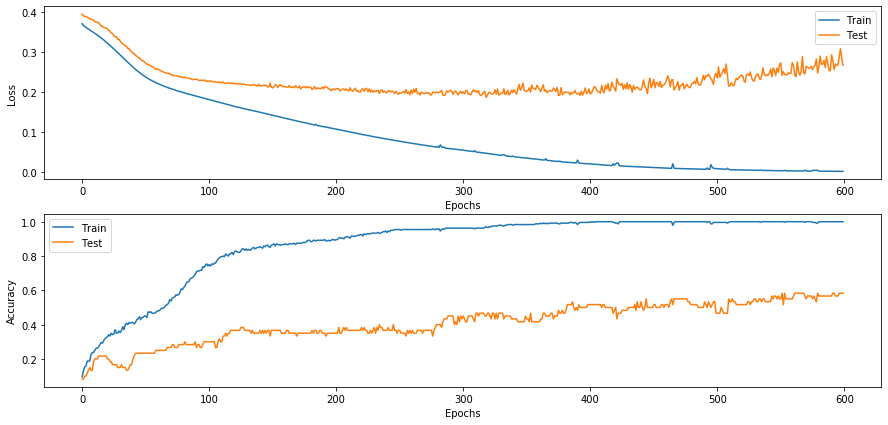

In [333]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].plot(train_loss)
ax[0].plot(test_loss)
ax[0].legend(['Train', 'Test'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

In [48]:
# Try out svm